In [0]:
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, History
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.models import Model, Sequential
from keras.losses import categorical_crossentropy
from keras import optimizers
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import string
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
!unzip Archive\ 3.zip

Archive:  Archive 3.zip
   creating: Assistant/
  inflating: Assistant/k.jpg         
  inflating: Assistant/H_.jpg        
  inflating: Assistant/comma.jpg     
  inflating: Assistant/equals.jpg    
  inflating: Assistant/plus.jpg      
  inflating: Assistant/dash.jpg      
  inflating: Assistant/hash.jpg      
  inflating: Assistant/<.jpg         
  inflating: Assistant/j.jpg         
  inflating: Assistant/h.jpg         
  inflating: Assistant/D_.jpg        
  inflating: Assistant/>.jpg         
  inflating: Assistant/Q_.jpg        
  inflating: Assistant/slash.jpg     
  inflating: Assistant/?.jpg         
  inflating: Assistant/i.jpg         
  inflating: Assistant/z.jpg         
  inflating: Assistant/m.jpg         
  inflating: Assistant/P_.jpg        
  inflating: Assistant/ampersant.jpg  
  inflating: Assistant/l.jpg         
  inflating: Assistant/E_.jpg        
  inflating: Assistant/y.jpg         
  inflating: Assistant/8.jpg         
  inflating: Assistant/at.jpg        
 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def gen_alphabet():
    small = [chr(i) for i in range(ord('a'), ord('z')+1)]
    big = [chr(i)+'_' for i in range(ord('A'), ord('Z')+1)]
    flatten = lambda l: [item for sublist in l for item in sublist]
    alphabet = flatten(zip(big, small))
    symbols = ['point', 'dash', 'comma', '!', '?', 'colon', 'semicolon', '>', 
               '<', 'equals', 'at', 'hash', 'dollar', 'percent', '^',
               'ampersant', 'asterics', 'round_open', 'round_close',
              'plus', 'backslash', 'slash', 'square_open', 'square_close', 'curly_open', 'curly_close']
    numbers = range(10)
    for symbol in symbols:
        alphabet.append(symbol)
    for number in numbers:
        alphabet.append(number)
    
    return alphabet
alphabet = gen_alphabet()

In [0]:
def gen_alphabet2():
    alphabet = list(string.ascii_lowercase)
    symbols = ['.', '-', ',', '!', '?', ':', ';', '>', 
               '<', '=', '@', '#', '$', '%', '^',
               '&', '*', '(', ')', '+', '\\', '/',
               '[', ']', '{', '}']
    numbers = list(string.digits)
    alphabet += symbols
    alphabet += numbers
    return alphabet
  
alphabet2 = gen_alphabet2()

In [0]:
temp = []
indx = 0
for i in range(len(alphabet)):
  if i <= 51:
    if not i % 2:
      temp.append(indx)
      temp.append(indx)
      indx += 1
  else:
    temp.append(indx)
    indx += 1

In [0]:
def read_one_img(path):
#     print(path)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)[1]
    return img

In [0]:
    # def normalize_images(images):
#     H, W = 28, 28
#     images = np.reshape(images, (-1, H * W))
#     numerator = images - np.expand_dims(np.mean(images, 1), 1)
#     denominator = np.expand_dims(np.std(images, 1), 1)
#     return np.reshape(numerator / (denominator + 1e-7), (-1, H, W))

def normalize_images(images):
    return np.array(images, np.float) / 255.0

In [0]:
class Dataset:
    def __init__(self):
        self._path = '{}/{}.jpg'
        self._font_names = [ name for name in os.listdir() if (not '.' in name) and ( not'_' in name) and ( not name=='drive')]
        self._indxs = np.zeros((49, 88))
        self._indxs[:] = np.arange(88)
        self._last_batch = None
        
    def gen_batches(self, seed=None):
        np.random.seed(seed)
        for row in range(49):
            self._indxs[row] = np.random.randint(49, size=88)
        self._last_batch = 0
    
    def get_batch(self):
        X = np.zeros((88, 28, 28, 1))
        y = np.zeros((88, 62))

        indx = 0
        for j, val in enumerate(self._indxs[self._last_batch+1]):
            path = self._path.format(self._font_names[int(val)], alphabet[j])
            X[indx] = read_one_img(path).reshape((28, 28, 1))
            y[indx][temp[j]] = 1
                
            indx += 1
        self._last_batch += 1
        
        indxs = np.random.permutation(88)
        
        return X[indxs], y[indxs]

In [0]:
def get_test():
  font_names = [name for name in os.listdir() if (not '.' in name) and ( not'_' in name) and ( not name=='drive')]
  rand = np.random.randint(len(font_names), size=1)[0]
  name = font_names[rand]
  imgs = [read_one_img(name+'/'+str(img) + '.jpg') for img in alphabet]
  labels = np.zeros((88, 62))

  for i, item in enumerate(temp):
    labels[i][item] = 1
    
  return imgs, labels, name

In [0]:
def create_model():
#   model = load_model('/content/drive/My Drive/handwritten_digit_recognition/ResNet164.h5')
  model = load_model('drive/My Drive/course_project/h5_models/new_mnist.h5')
  
  out = model.layers[-2].output
  out = Dense(62, activation='softmax', name='dense_final')(out)
  
  new_model = Model(input=model.inputs, output=out)
  
  return new_model

model = create_model()

W0831 12:14:11.878403 139644425693056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 12:14:11.897403 139644425693056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 12:14:11.927441 139644425693056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 12:14:11.928475 139644425693056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0831 12:14:11.930481 1396444256

In [0]:
# model = load_model('/content/drive/My Drive/course_project/h5_models/model_more_classes2.h5')
# model.load_weights('/content/drive/My Drive/course_project/h5_models/weights_75.h5')
# for i in range(500):
#   model.layers[i].trainable = False

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128 

In [0]:
dataset = Dataset()
dataset.gen_batches()
batch = dataset.get_batch()

In [0]:
len(dataset._font_names)

49

True: ;
Predicted: ;


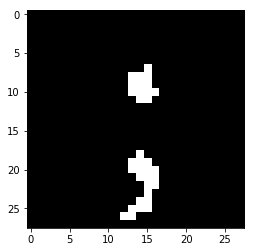

In [0]:
n = 2
temp_img = batch[0][n].copy()
plt.imshow(np.reshape(temp_img, (28, 28)), cmap='gray')
temp_img = normalize_images(temp_img)
print('True: {}'.format(alphabet2[np.argmax(batch[1][n])]))
print('Predicted: {}'.format(alphabet2[np.argmax(model.predict(np.reshape(temp_img, (1, 28, 28, 1))))]))

In [0]:
$model.compile(loss=categorical_crossentropy,
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [0]:
# when_to_save = [15, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250]
when_to_save = [5, 10, 15, 20, 30, 40, 50]

In [0]:
%%time
# last_epoch = 150
epochs = 50
test_losses_cache = []
test_accuracy_cache = []
train_losses_cache = []
train_accuracy_cache = []
for epoch in range(epochs):
  if epoch in when_to_save:
    model.save_weights('/content/drive/My Drive/course_project/h5_models/new_model_weights_{}.h5'.format(epoch))
  dataset.gen_batches()
  train_losses = []
  train_accuracy = []
  test_losses = []
  test_accuracy = []
  X_test, y_test, name = get_test()
  X_test = normalize_images(X_test)
  X_test = np.reshape(X_test, (-1, 28, 28, 1))
  for i in range(48):
    X, y = dataset.get_batch()
    X = normalize_images(X)
    X = np.reshape(X, (-1, 28, 28, 1))
    model.train_on_batch(X, y)
    score_train = model.evaluate(X, y, verbose=0)
    score_test = model.evaluate(X_test, y_test, verbose=0)
    train_losses.append(score_train[0])
    train_accuracy.append(score_train[1])
    test_losses.append(score_test[0])
    test_accuracy.append(score_test[1])
    

  print('Epoch: %d' % (epoch))
  print('Tested on ' + name)
  print('   Train Loss: %.5f \t\t Test Loss: %.5f' % (np.mean(train_losses), np.mean(test_losses)))
  print('   Train Accuracy: %.3f \t Test Accuracy: %.3f' % (np.mean(train_accuracy), np.mean(test_accuracy)))
#   print('   Train Loss: %.5f' % (np.mean(train_losses)))
#   print('   Train Accuracy: %.3f' % (np.mean(train_accuracy)))
  
  train_losses_cache.append(np.mean(train_losses))
  train_accuracy_cache.append(np.mean(train_accuracy))
  test_losses_cache.append(np.mean(test_losses))
  test_accuracy_cache.append(np.mean(test_accuracy))

Epoch: 0
Tested on Varela
   Train Loss: 1.30116 		 Test Loss: 1.13445
   Train Accuracy: 0.691 	 Test Accuracy: 0.735
Epoch: 1
Tested on Courier
   Train Loss: 0.25728 		 Test Loss: 0.42563
   Train Accuracy: 0.937 	 Test Accuracy: 0.913
Epoch: 2
Tested on Fira
   Train Loss: 0.13760 		 Test Loss: 0.04306
   Train Accuracy: 0.962 	 Test Accuracy: 0.999
Epoch: 3
Tested on Impact
   Train Loss: 0.08797 		 Test Loss: 0.65597
   Train Accuracy: 0.977 	 Test Accuracy: 0.813
Epoch: 4
Tested on Hind
   Train Loss: 0.06624 		 Test Loss: 0.02536
   Train Accuracy: 0.979 	 Test Accuracy: 0.990
Epoch: 5
Tested on Maven
   Train Loss: 0.04481 		 Test Loss: 0.03558
   Train Accuracy: 0.987 	 Test Accuracy: 0.986
Epoch: 6
Tested on Impact
   Train Loss: 0.03648 		 Test Loss: 0.34918
   Train Accuracy: 0.989 	 Test Accuracy: 0.896
Epoch: 7
Tested on Dosis
   Train Loss: 0.02641 		 Test Loss: 0.07554
   Train Accuracy: 0.995 	 Test Accuracy: 0.977
Epoch: 8
Tested on Garamond
   Train Loss: 0.02375 		

In [0]:
model.save_weights('/content/drive/My Drive/course_project/h5_models/new_model_weights_{}.h5'.format(epochs))

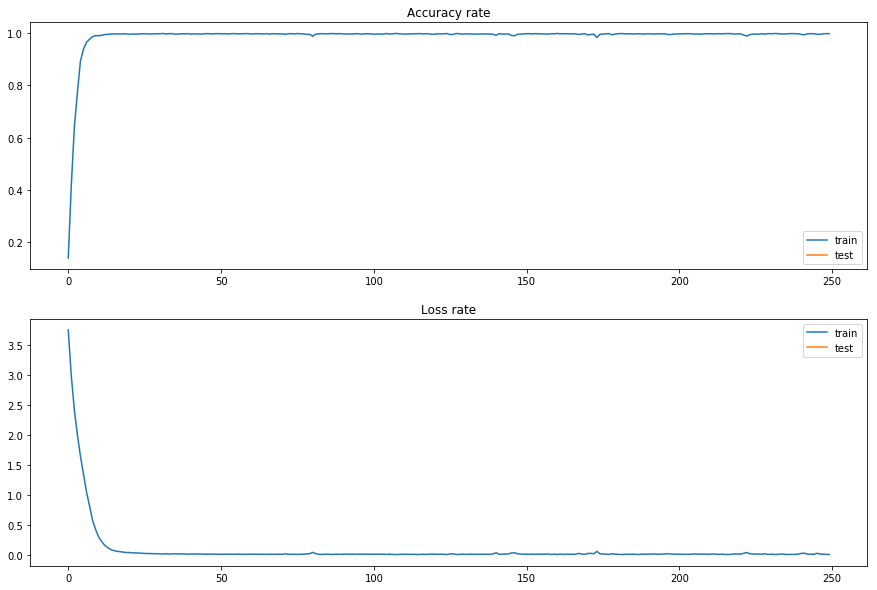

In [0]:
 f, ax = plt.subplots(2 , figsize=(15, 10))

ax[0].plot(train_accuracy_cache, label='train')
ax[0].plot(test_accuracy_cache, label='test')
ax[0].set_title('Accuracy rate')
ax[0].legend()

ax[1].plot(train_losses_cache, label='train')
ax[1].plot(test_losses_cache, label='test')
ax[1].set_title('Loss rate')
ax[1].legend()